## Time Series Analysis and Forecasting for Bitcoin (BTC) using ARIMA
### Executive Summary

This project employs time series analysis and forecasting techniques, specifically leveraging the ARIMA model, to gain insights into the historical trends and make predictions for Bitcoin (BTC) prices. The analysis covers data resampling, stationarity checks, Box-Cox transformations, differencing, SARIMA model selection, and forecasting.

#### Key Steps and Findings:

1. **Data Exploration and Resampling:**
   - Bitcoin price data is loaded and resampled at daily, monthly, quarterly, and annual frequencies, offering a comprehensive view of the price trends.


2. **Seasonal-Trend Decomposition using LOESS (STL):**
   - STL decomposition reveals the underlying components of the time series, including trend, seasonal, and residual aspects.


3. **Stationarity Analysis:**
   - Dickey–Fuller tests are applied before and after Box-Cox transformation, ensuring stationarity for more reliable modeling.


4. **Differencing for Stationarity:**
   - Seasonal and regular differencing are employed to achieve stationarity, allowing for more accurate modeling.


5. **SARIMA Model Selection:**
   - Grid search is conducted to identify the optimal parameters for the SARIMA model, using the AIC as a criterion for selection.


6. **Model Diagnostic and Residual Analysis:**
   - Residual analysis confirms the model's adequacy, and the Dickey–Fuller test validates the stationarity of the residuals.


7. **Forecasting:**
   - The SARIMA model is utilized to forecast Bitcoin prices into the future, providing insights into potential trends.


8. **Inverse Transformation and Final Forecast Visualization:**
   - Forecasts are transformed back to the original data scale using the inverse Box-Cox transformation, and the results are visualized alongside historical data.


#### Conclusion:

The ARIMA model has been successfully applied to capture patterns and dynamics within the Bitcoin price time series. The forecasting results provide valuable information for decision-making and risk management in the cryptocurrency market. 

## Data Loading and Initial Exploration

The historical data of Bitcoin (BTC) is downloaded from Yahoo Finance https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD , This csv contains data from 2014-09-17 to 2023-11-17.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')


#Loading the BTC CSV data
btc_data = pd.read_csv('/kaggle/input/btc-usd-2014-2023/BTC-USD.csv')
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3344,2023-11-13,37070.304688,37405.117188,36399.605469,36502.355469,36502.355469,19057712790
3345,2023-11-14,36491.789063,36753.351563,34948.500000,35537.640625,35537.640625,23857403554
3346,2023-11-15,35548.113281,37964.894531,35383.781250,37880.582031,37880.582031,27365821679
3347,2023-11-16,37879.980469,37934.625000,35545.472656,36154.769531,36154.769531,26007385366


### Time Series Preprocessing: Resampling BTC Data

In [2]:
#Ensuring the 'Date' column to datetime type for proper time series handling
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

#Setting the 'Date' column as the index
btc_data.set_index('Date', inplace=True)

#Resample to daily, monthly, quarterly and annual frequency
btc_data_daily = btc_data.resample('D').mean()
btc_data_monthly = btc_data.resample('M').mean()
btc_data_quarterly = btc_data.resample('Q').mean()
btc_data_annual = btc_data.resample('Y').mean()

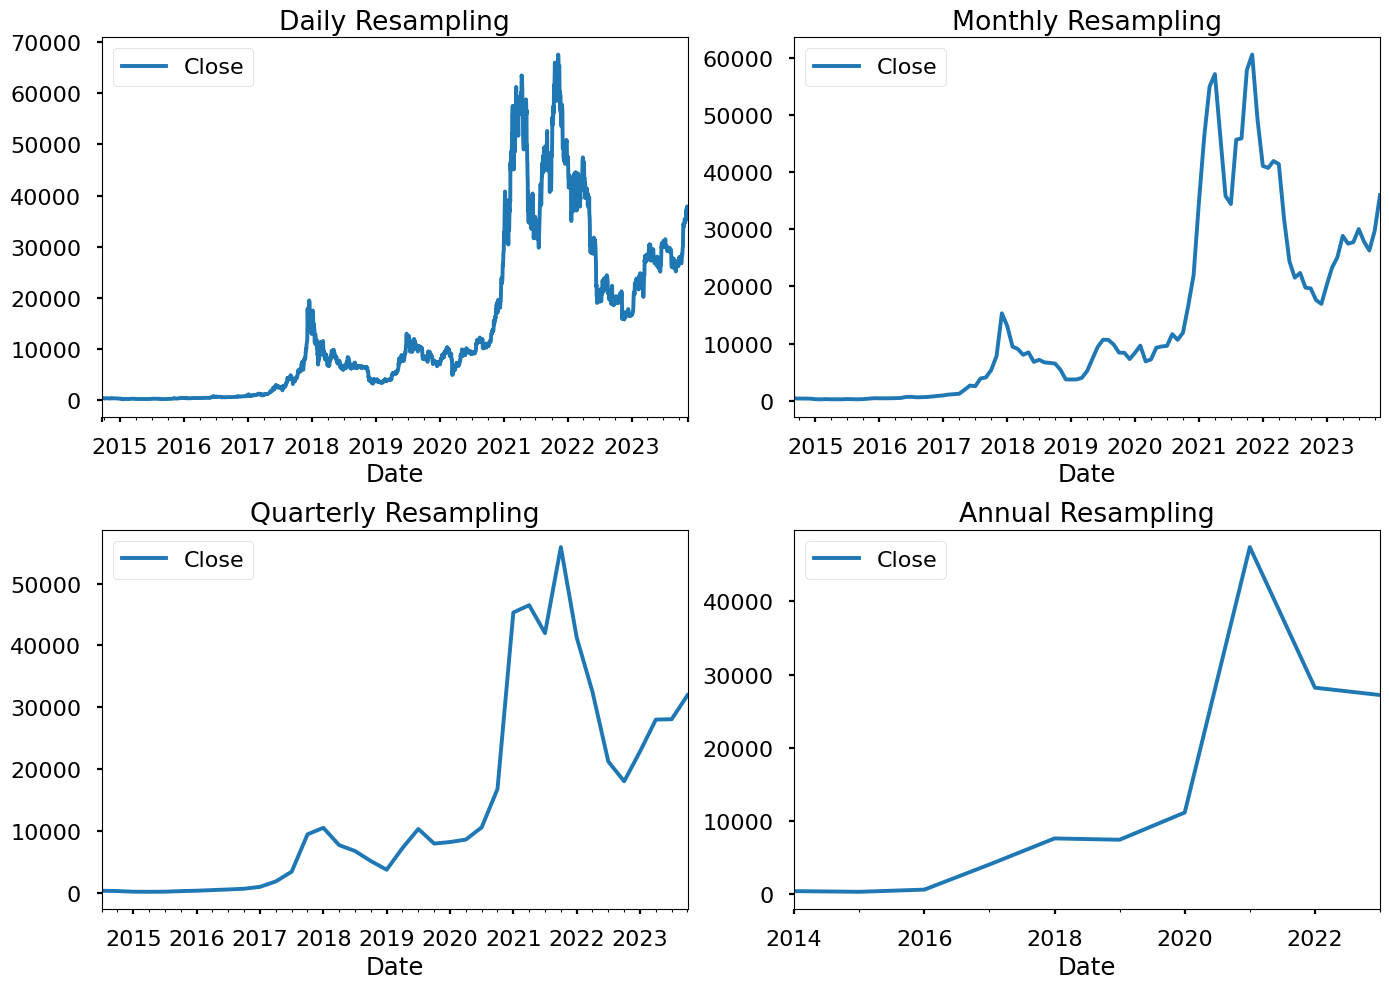

In [3]:
#Plotting for each frequency
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

btc_data_daily['Close'].plot(ax=axes[0, 0], title='Daily Resampling', legend=True)
btc_data_monthly['Close'].plot(ax=axes[0, 1], title='Monthly Resampling', legend=True)
btc_data_quarterly['Close'].plot(ax=axes[1, 0], title='Quarterly Resampling', legend=True)
btc_data_annual['Close'].plot(ax=axes[1, 1], title='Annual Resampling', legend=True)

plt.tight_layout()
plt.show()

### STL-decomposition and  Stationarity check of the series

<Figure size 1500x700 with 0 Axes>

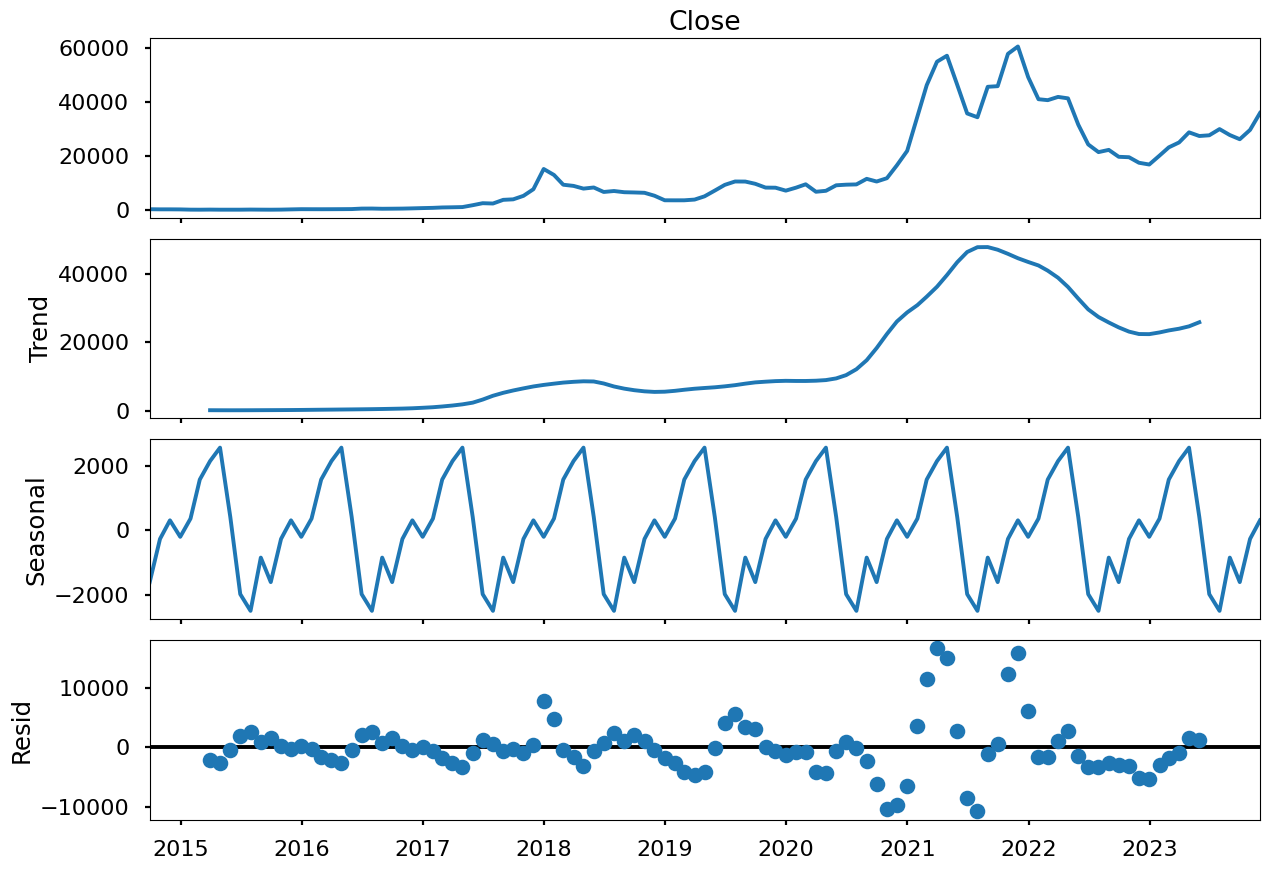

Dickey–Fuller test before transformation:
ADF Statistic: -1.3495651930771784
p-value: 0.6062024265313833
Critical Values: {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}
The time series is likely non-stationary (fail to reject the null hypothesis)


In [4]:
#STL decomposition
plt.figure(figsize=[15, 7])
result = sm.tsa.seasonal_decompose(btc_data_monthly['Close'], period=12)
result.plot()

plt.show()

#Dickey-Fuller test results
adf_result = sm.tsa.adfuller(btc_data_monthly['Close'])
print("Dickey–Fuller test before transformation:")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

#Checking stationarity
if adf_result[1] <= 0.05:
    print("The time series is likely stationary (reject the null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis)")

### Box-Cox Transformations

In [5]:
#Box-Cox transformation
btc_data_monthly['Close_box'], lmbda = stats.boxcox(btc_data_monthly['Close'])

#Checking stationarity
result_after = sm.tsa.adfuller(btc_data_monthly['Close_box'])

print("\nDickey–Fuller test after transformation:")
print("ADF Statistic:", result_after[0])
print("p-value:", result_after[1])
print("Critical Values:", result_after[4])
if result_after[1] <= 0.05:
    print("The transformed time series is likely stationary (reject the null hypothesis)")
else:
    print("The transformed time series is likely non-stationary (fail to reject the null hypothesis)")


Dickey–Fuller test after transformation:
ADF Statistic: -1.0954025670527017
p-value: 0.7169018215637171
Critical Values: {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}
The transformed time series is likely non-stationary (fail to reject the null hypothesis)


### Seasonal Differentiation

In [6]:
#Seasonal differencing
btc_data_monthly['prices_box_diff'] = btc_data_monthly['Close_box'] - btc_data_monthly['Close_box'].shift(12)

#Droping NaN values resulting from the differencing
btc_data_monthly.dropna(inplace=True)

#Checking Stationarity
adf_result_diff = sm.tsa.adfuller(btc_data_monthly['prices_box_diff'])

print("Dickey–Fuller test after seasonal differencing:")
print("ADF Statistic:", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
print("Critical Values:", adf_result_diff[4])
if adf_result_diff[1] <= 0.05:
    print("The differenced time series is likely stationary (reject the null hypothesis)")
else:
    print("The differenced time series is likely non-stationary (fail to reject the null hypothesis)")

Dickey–Fuller test after seasonal differencing:
ADF Statistic: -1.953431048583727
p-value: 0.30735755462295045
Critical Values: {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
The differenced time series is likely non-stationary (fail to reject the null hypothesis)


### Regular Differentiation

<Figure size 1500x700 with 0 Axes>

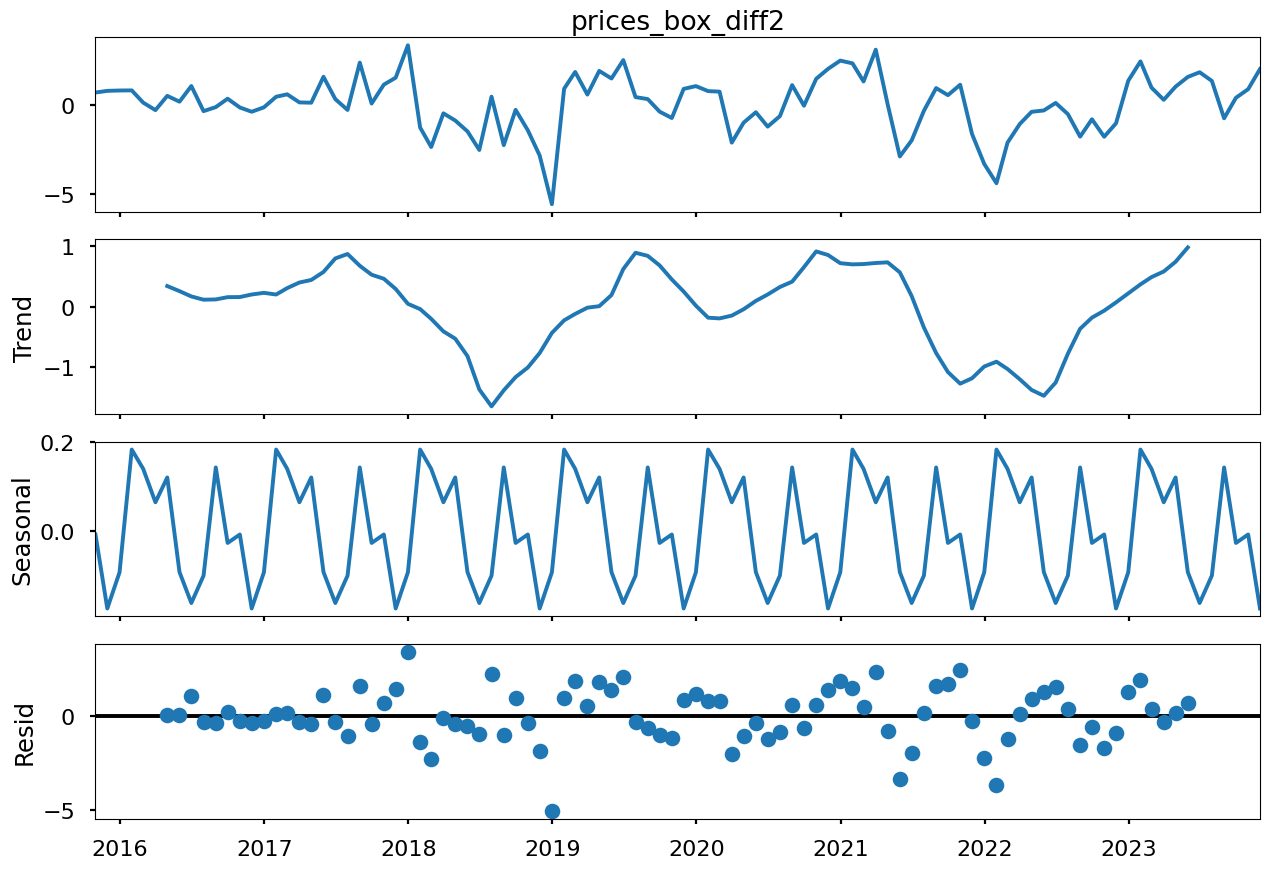

Dickey–Fuller test after regular differencing:
ADF Statistic: -4.4404526097381485
p-value: 0.0002515440935116996
Critical Values: {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}
The doubly differenced time series is likely stationary (reject the null hypothesis)


In [7]:
#Regular differencing
btc_data_monthly['prices_box_diff2'] = btc_data_monthly['prices_box_diff'] - btc_data_monthly['prices_box_diff'].shift(1)

#Droping NaN values resulting from the differencing
btc_data_monthly.dropna(inplace=True)

#Plotting STL decomposition
plt.figure(figsize=(15, 7))
sm.tsa.seasonal_decompose(btc_data_monthly['prices_box_diff2']).plot()

plt.show()

#Checking Stationarity
adf_result_diff2 = sm.tsa.adfuller(btc_data_monthly['prices_box_diff2'])

print("Dickey–Fuller test after regular differencing:")
print("ADF Statistic:", adf_result_diff2[0])
print("p-value:", adf_result_diff2[1])
print("Critical Values:", adf_result_diff2[4])
if adf_result_diff2[1] <= 0.05:
    print("The doubly differenced time series is likely stationary (reject the null hypothesis)")
else:
    print("The doubly differenced time series is likely non-stationary (fail to reject the null hypothesis)")

### Model Selection

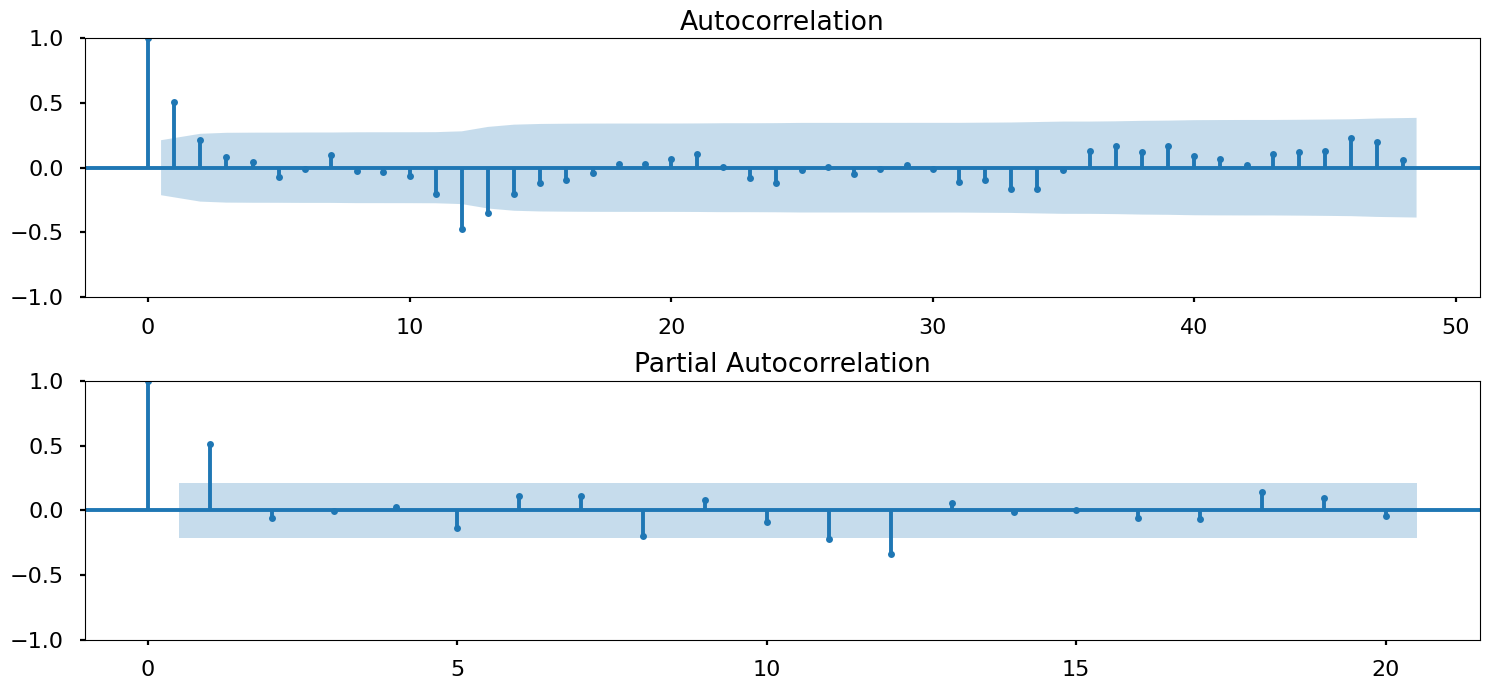

In [8]:
#Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15, 7))
ax1 = plt.subplot(211)
sm.graphics.tsa.plot_acf(btc_data_monthly['prices_box_diff2'][13:].values.squeeze(), lags=48, ax=ax1)
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(btc_data_monthly['prices_box_diff2'][13:].values.squeeze(), ax=ax2)  # Using the default number of lags
plt.tight_layout()
plt.show()

In [9]:
#Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(f"Total parameter combinations: {len(parameters_list)}")

#Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for i, param in enumerate(parameters_list, start=1):
    print(f"Fitting model {i}/{len(parameters_list)} with parameters: {param}")
    try:
        model = sm.tsa.statespace.SARIMAX(
            btc_data_monthly['Close_box'],
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except Exception as e:
        print(f"Error fitting model with parameters {param}: {e}")
        continue

    aic = model.aic
    results.append([param, aic])

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param

print(f"\nBest model AIC: {best_aic}")
print(f"Best model parameters: {best_param}")

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

Total parameter combinations: 54
Fitting model 1/54 with parameters: (0, 0, 0, 0)
Fitting model 2/54 with parameters: (0, 0, 0, 1)
Fitting model 3/54 with parameters: (0, 0, 1, 0)
Fitting model 4/54 with parameters: (0, 0, 1, 1)
Fitting model 5/54 with parameters: (0, 0, 2, 0)
Fitting model 6/54 with parameters: (0, 0, 2, 1)
Fitting model 7/54 with parameters: (0, 1, 0, 0)
Fitting model 8/54 with parameters: (0, 1, 0, 1)
Fitting model 9/54 with parameters: (0, 1, 1, 0)
Fitting model 10/54 with parameters: (0, 1, 1, 1)
Fitting model 11/54 with parameters: (0, 1, 2, 0)
Fitting model 12/54 with parameters: (0, 1, 2, 1)
Fitting model 13/54 with parameters: (0, 2, 0, 0)
Fitting model 14/54 with parameters: (0, 2, 0, 1)
Fitting model 15/54 with parameters: (0, 2, 1, 0)
Fitting model 16/54 with parameters: (0, 2, 1, 1)
Fitting model 17/54 with parameters: (0, 2, 2, 0)
Fitting model 18/54 with parameters: (0, 2, 2, 1)
Fitting model 19/54 with parameters: (1, 0, 0, 0)
Fitting model 20/54 with p

### Analysis of Residues

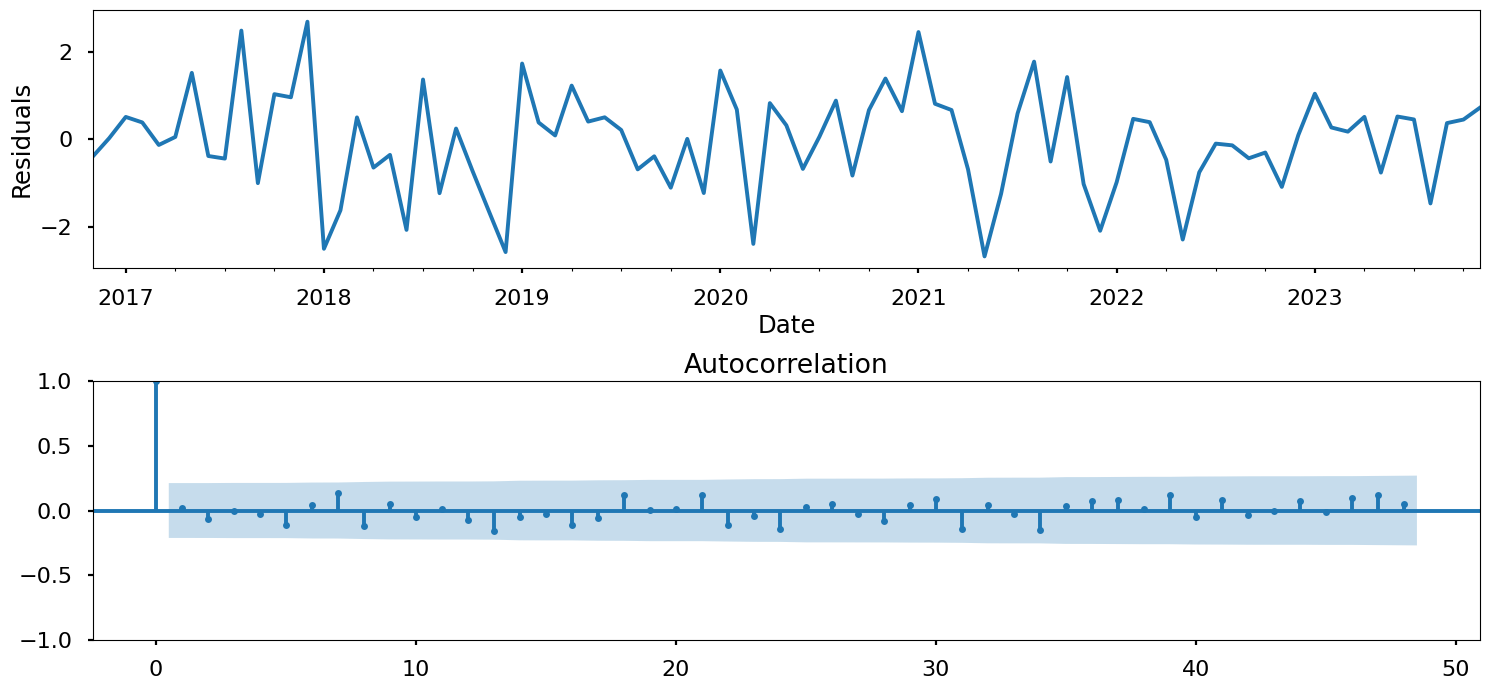

Dickey–Fuller test: p=0.000000


In [10]:
#STL-decomposition and Residual Analysis
plt.figure(figsize=(15, 7))

#Plotting Residuals
plt.subplot(2, 1, 1)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

#Plotting ACF of Residuals
ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

# Dickey–Fuller test for stationarity
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

## Prediction
We will predict bitcoin prices by months.

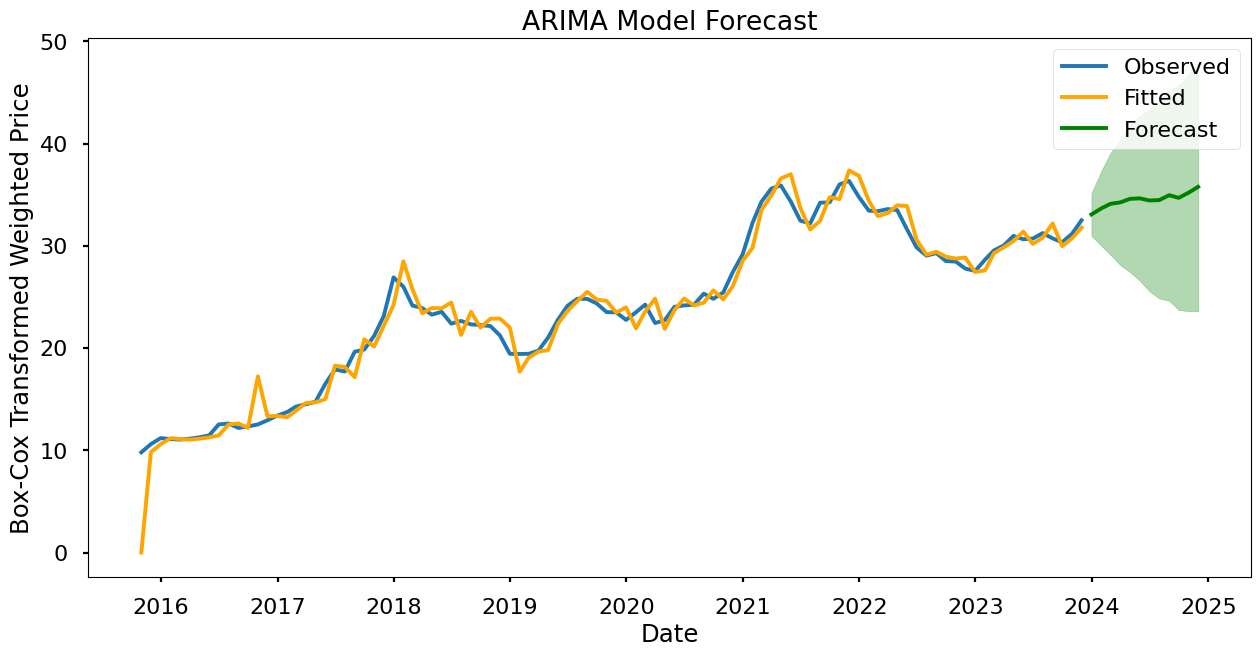

In [11]:
#Number of periods to forecast into the future
forecast_periods = 12

#Forecast
forecast = best_model.get_forecast(steps=forecast_periods)

#Extractting forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

#Assuming your data has a datetime index
forecast_index = pd.date_range(start=btc_data_monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

#Plotting the observed values, the fitted values, and the forecast
plt.figure(figsize=(15, 7))
plt.plot(btc_data_monthly['Close_box'], label='Observed')
plt.plot(best_model.fittedvalues, label='Fitted', color='orange')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='green', alpha=0.3)

plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Box-Cox Transformed Weighted Price')
plt.legend()
plt.show()

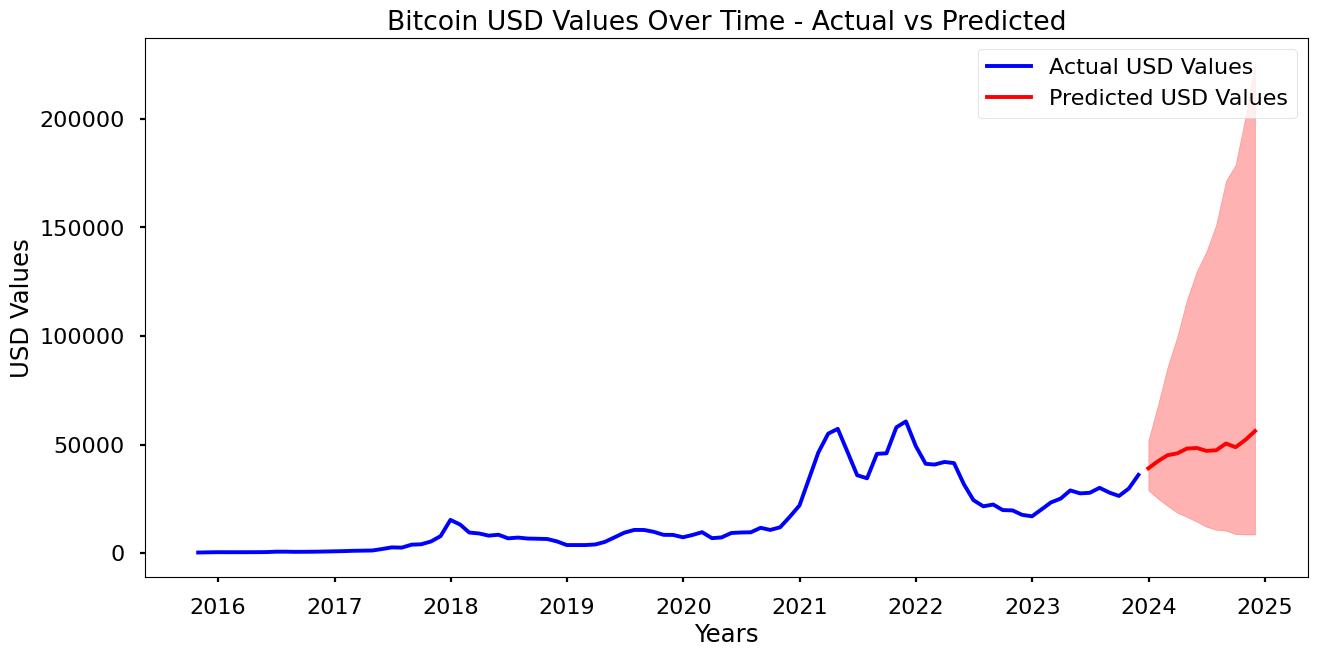

In [12]:
#Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

#Creating a new column with the original Close values (inverse Box-Cox if applied)
btc_data_monthly['Original_Close'] = invboxcox(btc_data_monthly['Close_box'], lmbda)

#Number of periods to forecast into the future
forecast_periods = 12

#Forecast
forecast = best_model.get_forecast(steps=forecast_periods)

#Extractting forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

#Datetime index
forecast_index = pd.date_range(start=btc_data_monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

#Inverse transforming the forecasted values
forecasted_usd = invboxcox(forecast_mean, lmbda)

#Plotting USD values against years for both actual and predicted
plt.figure(figsize=(15, 7))
plt.plot(btc_data_monthly.index, btc_data_monthly['Original_Close'], label='Actual USD Values', color='blue')
plt.plot(forecast_index, forecasted_usd, label='Predicted USD Values', color='red')
plt.fill_between(forecast_index, invboxcox(forecast_conf_int.iloc[:, 0], lmbda), invboxcox(forecast_conf_int.iloc[:, 1], lmbda), color='red', alpha=0.3)

plt.title('Bitcoin USD Values Over Time - Actual vs Predicted')
plt.xlabel('Years')
plt.ylabel('USD Values')
plt.legend()
plt.show()

In [13]:
#Creating a DataFrame to store the predicted values and corresponding dates
predicted_df = pd.DataFrame({'Predicted_USD': forecasted_usd})
print(predicted_df)

            Predicted_USD
2023-12-31   39024.472108
2024-01-31   42377.028275
2024-02-29   45050.200420
2024-03-31   45925.780216
2024-04-30   48112.057136
2024-05-31   48415.795299
2024-06-30   47083.300884
2024-07-31   47323.416130
2024-08-31   50450.690908
2024-09-30   48753.940075
2024-10-31   52138.780086
2024-11-30   56200.700723
